In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Step 1: Prepare the data
data = {
    'Month': pd.date_range(start='2015-01', end='2023-12', freq='MS'),
    'EV': [
        181, 186, 227, 178, 199, 296, 382, 719, 989, 1143, 1451, 2441,
        2200, 2931, 5200, 4348, 4866, 5982, 5476, 5348, 5351, 8069, 5914, 6032,
        6866, 7319, 10352, 8902, 11686, 12791, 13613, 12655, 11512, 12436, 15409, 13037,
        14590, 12270, 13264, 12415, 13628, 13696, 16315, 16819, 19639, 22012, 21630, 25279,
        27974, 23941, 27522, 22573, 20580, 19441, 19970, 20211, 23016, 25874, 27714, 23417,
        24149, 22523, 22272, 1525, 2981, 12904, 14259, 16724, 20677, 22074, 25779, 28043,
        30177, 30987, 40599, 23171, 6559, 19911, 41056, 42999, 47203, 53808, 57140, 63847,
        62475, 67672, 91418, 84895, 85643, 88511, 93266, 107737, 114328, 145033, 147557, 129690,
        133323, 138912, 179041, 139367, 184766, 129218, 139942, 153026, 155650, 168116, 180627, 164253
    ]
}

df = pd.DataFrame(data)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['EV']])

# Step 2: Create sequences (X: input, y: target)
sequence_length = 12

def create_sequences(data, sequence_length):
    X = []
    y = []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data, sequence_length)

X = np.reshape(X, (X.shape[0], X.shape[1], 1))

In [ ]:
!pip install keras-tuner -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 9.3 MB/s eta 0:00:00


In [ ]:
from kerastuner.tuners import RandomSearch
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

def build_model(hp):
    model = Sequential()
    model.add(LSTM(
        units=hp.Int('units', min_value=50, max_value=200, step=50),
        return_sequences=True,
        input_shape=(X.shape[1], X.shape[2])
    ))
    model.add(Dropout(hp.Choice('dropout_rate', values=[0.1, 0.2, 0.3])))
    model.add(LSTM(units=hp.Int('units', min_value=50, max_value=200, step=50)))
    model.add(Dropout(hp.Choice('dropout_rate', values=[0.1, 0.2, 0.3])))
    model.add(Dense(units=1))

    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[1e-3, 5e-4, 1e-4])),
        loss='mean_squared_error'
    )
    return model

tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='my_dir',
    project_name='EV_sales_LSTM'
)

tuner.search(X, y, epochs=50, batch_size=1, validation_split=0.2)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best units: {best_hps.get('units')}, Best dropout rate: {best_hps.get('dropout_rate')}, Best learning rate: {best_hps.get('learning_rate')}")


Trial 10 Complete [00h 01m 50s]
val_loss: 0.01814245618879795

Best val_loss So Far: 0.015598729252815247
Total elapsed time: 00h 15m 36s
Best units: 200, Best dropout rate: 0.2, Best learning rate: 0.001


Epoch 1/200
76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.0091 - val_loss: 0.1024
Epoch 2/200
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0032 - val_loss: 0.1598
Epoch 3/200
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0020 - val_loss: 0.6207
Epoch 4/200
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0021 - val_loss: 0.2041
Epoch 5/200
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0022 - val_loss: 0.0470
Epoch 6/200
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0048 - val_loss: 0.0170
Epoch 7/200
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0024 - val_loss: 1.3136
Epoch 8/200
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0024 - val_loss: 0.0142
Epoch 9/200
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0023 - val_loss: 0.0443
Epoch 10/200
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0030 - val_loss: 0.0758
Epoch 11/200
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0037 - val_loss: 0.0215
Epoch 12/200
76/76 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step

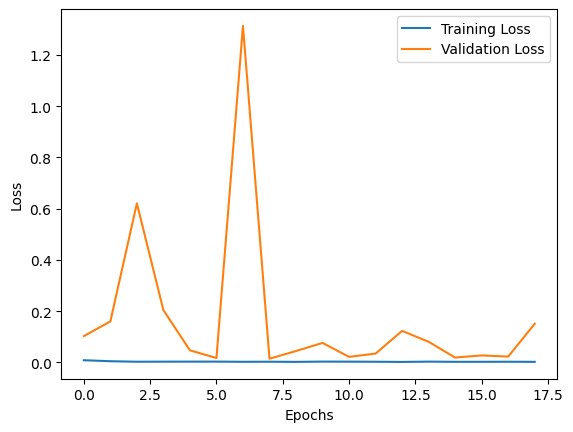

In [ ]:
model = tuner.hypermodel.build(best_hps)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X, y, epochs=200, batch_size=1, validation_split=0.2, callbacks=[early_stopping])

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScal

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScal

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScal

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScal

Text(0.5, 1.0, 'EV Sales: Actual (2015-2023) vs Predicted (2024)')

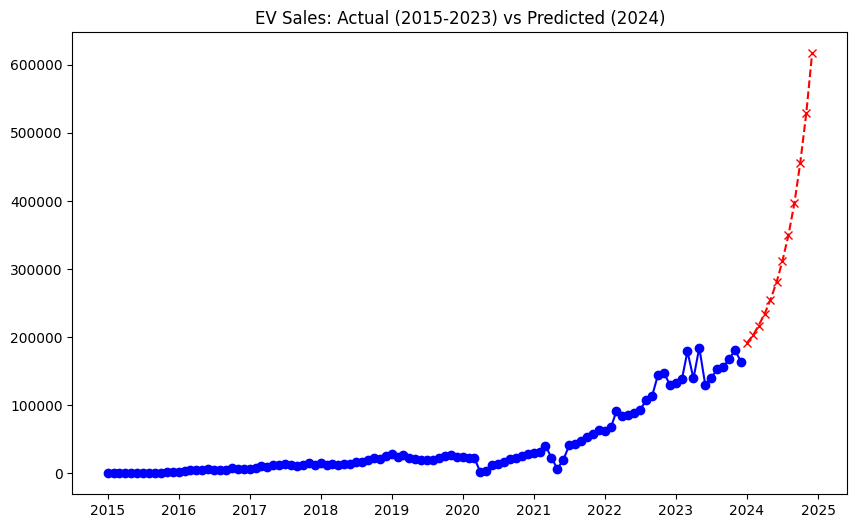

In [ ]:
# Ensure 'Scaled_Year' is created by extracting the year from the 'Month' column
if 'Scaled_Year' not in df.columns:
    df['Year'] = df['Month'].dt.year  # Extract year from Month
    year_scaler = MinMaxScaler(feature_range=(0, 1))
    df['Scaled_Year'] = year_scaler.fit_transform(df[['Year']])
last_sequence = scaled_data[-sequence_length:]
last_year_sequence = df[['Scaled_Year']].values[-sequence_length:]

predicted_ev_sales_2024 = []

for month in range(12):

    sequence = last_sequence
    sequence = np.reshape(sequence, (1, sequence_length, 1))

    predicted_value = model.predict(sequence)
    predicted_value = scaler.inverse_transform(predicted_value)
    predicted_ev_sales_2024.append(predicted_value[0][0])
    last_sequence = np.vstack((last_sequence[1:], scaler.transform([[predicted_value[0][0]]])))

    last_year_sequence = np.vstack((last_year_sequence[1:], [[year_scaler.transform([[2024]])[0][0]]]))

months_2024 = pd.date_range(start="2024-01", end="2024-12", freq='MS')

plt.figure(figsize=(10, 6))
plt.plot(df['Month'], df['EV'], label='Actual Sales (2015-2023)', marker='o', color='blue')
plt.plot(months_2024, predicted_ev_sales_2024, label='Predicted Sales (2024)', marker='x', linestyle='--', color='red')

plt.title('EV Sales: Actual (2015-2023) vs Predicted (2024)')